In [ ]:
import torch
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
!pip install diffusers
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 4.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinu

In [ ]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

# 1. Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Now instead of loading the pre-defined scheduler, we use the K-LMS scheduler instead.

In [ ]:
from diffusers import LMSDiscreteScheduler
from PIL import Image

scheduler = LMSDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

Next we move the models to the GPU.

In [ ]:
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

We now define the parameters we'll use to generate images.

In [ ]:
prompt = ["a blue couch"]

height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion

num_inference_steps = 100            # Number of denoising steps

guidance_scale = 7.5                # Scale for classifier-free guidance

generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise

batch_size = 1

First, we get the text_embeddings for the prompt. These embeddings will be used to condition the UNet model.

In [ ]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

In [ ]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

For classifier-free guidance, we need to do two forward passes. One with the conditioned input , and another with the unconditional embeddings .

In [ ]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

Generate the intial random noise.

In [ ]:
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)

<ipython-input-91-132bcdf2870d>:2: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


In [ ]:
latents.shape

torch.Size([1, 4, 64, 64])

In [ ]:
scheduler.set_timesteps(num_inference_steps)

The K-LMS scheduler needs to multiply the latents by its sigma values.

In [ ]:
latents = latents * scheduler.init_noise_sigma

Denoising loop.

In [ ]:
from tqdm.auto import tqdm
from torch import autocast

a=0
images_arr=[]
for t in tqdm(scheduler.timesteps):
  # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
  latent_model_input = torch.cat([latents] * 2)

  latent_model_input = scheduler.scale_model_input(latent_model_input, t)

  # predict the noise residual
  with torch.no_grad():
    noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

  # perform guidance
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

  # compute the previous noisy sample x_t -> x_t-1
  latents = scheduler.step(noise_pred, t, latents).prev_sample

  a+=1
  if a%10 == 0:
    temp = 1 / 0.18215 * latents
    image = vae.decode(temp).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    images_arr.append(pil_images[0])

  0%|          | 0/100 [00:00<?, ?it/s]

We now use the vae to decode the generated latents back into the image.

In [ ]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents

with torch.no_grad():
  image = vae.decode(latents).sample

In [ ]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

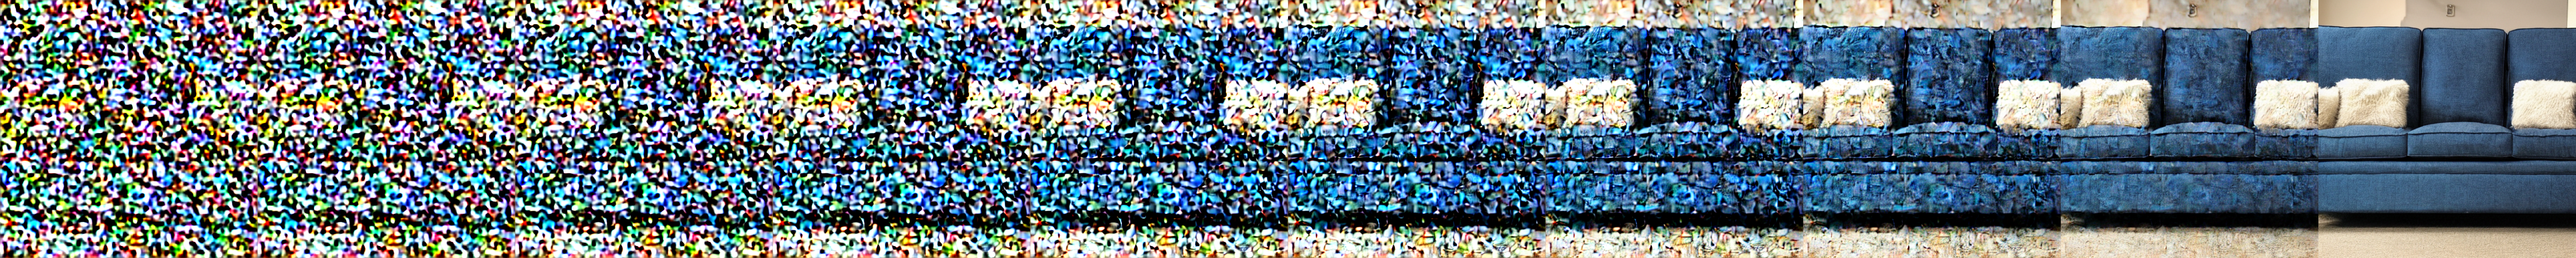

In [ ]:
image_grid(images_arr, rows=1, cols=len(images_arr))

We convert the image to PIL so we can display or save it.

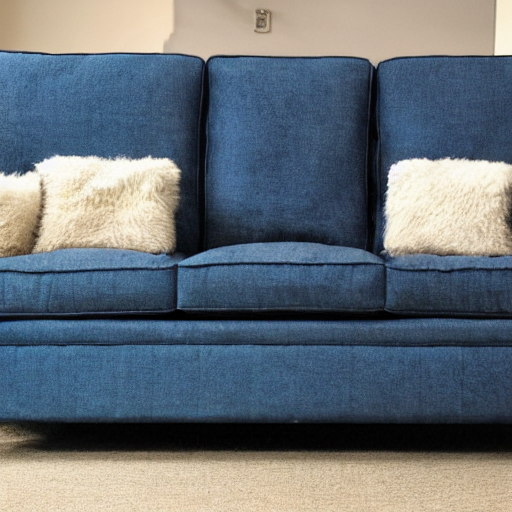

In [ ]:
from PIL import Image

image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

##Adapter

In [ ]:
!pip install controlnet_aux

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.4/202.4 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.3 MB/s eta 0:00:00
  Created wheel for controlnet_aux: filename=controlnet_aux-0.0.7-py3-none-any.whl size=274340 sha256=37591921e25f555005831bee3ef4b8bfa8605fb65616e55b75f3402d2308b67a
  Stored in directory: /root/.cache/pip/wheels/1e/3e/93/6678b4c0bc2ec31d53409b25d4189cbb08bae843e8b2b78e52
Successfully built controlnet_aux


In [ ]:
from diffusers import StableDiffusionXLAdapterPipeline, T2IAdapter, EulerAncestralDiscreteScheduler, AutoencoderKL
from diffusers.utils import load_image, make_image_grid
from controlnet_aux.lineart import LineartDetector
import torch

# load adapter
adapter = T2IAdapter.from_pretrained(
  "TencentARC/t2i-adapter-lineart-sdxl-1.0", torch_dtype=torch.float16, varient="fp16"
).to("cuda")


/usr/local/lib/python3.10/dist-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/controlnet_aux/segment_anything/modeling/tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_5m_224 in registry with controlnet_aux.segment_anything.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/usr/local/lib/python3.10/dist-packages/controlnet_aux/segment_anything/modeling/tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_11m_224 in registry with controlnet_aux.segment_anything.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.

config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/316M [00:00<?, ?B/s]

In [ ]:
# load euler_a scheduler
model_id = 'stabilityai/stable-diffusion-xl-base-1.0'
euler_a = EulerAncestralDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

In [ ]:
vae=AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

In [ ]:
pipe = StableDiffusionXLAdapterPipeline.from_pretrained(
    model_id, vae=vae, adapter=adapter, scheduler=euler_a, torch_dtype=torch.float16, variant="fp16",
).to("cuda")
#pipe.enable_xformers_memory_efficient_attention()

line_detector = LineartDetector.from_pretrained("lllyasviel/Annotators").to("cuda")

model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

sk_model.pth:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

sk_model2.pth:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

In [ ]:
!pip install fastparquet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 40.3 MB/s eta 0:00:00


In [ ]:
!pip install datasets
from datasets import load_dataset


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.1 MB/s eta 0:00:00


In [ ]:
dataset = load_dataset("zoheb/sketch-scene", split="train")

In [ ]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 9999
})

In [ ]:
image = dataset[0].get("image")

In [ ]:
import cv2
import numpy as np
img_arr = np.array(image)
invert = cv2.bitwise_not(img_arr)

In [ ]:
im = Image.fromarray(invert)

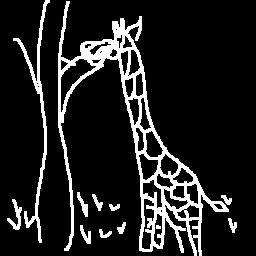

In [ ]:
im

In [ ]:
image = line_detector(
    im, detect_resolution=384, image_resolution=1080
)

In [ ]:
prompt = "giraffe is eating leaves from the tree, 4k photo"
negative_prompt = "anime, cartoon, graphic, text, painting, crayon, graphite, abstract, glitch, deformed, mutated, ugly, disfigured"
gen_images = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=image,
    num_inference_steps=30,
    adapter_conditioning_scale=0.8,
    guidance_scale=7.5,
).images[0]

  0%|          | 0/30 [00:00<?, ?it/s]

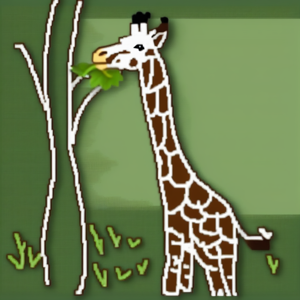

In [ ]:
gen_images.resize((300,300))